In [1]:
from pathlib import Path
import time
from itertools import product

import h5py
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.ndimage import gaussian_filter, rotate

import torch
from tqdm.auto import tqdm

import sklearn.cluster as skc
import sklearn.metrics as skm
from torch_dct import dct_2d
from scipy.ndimage import zoom
from scipy import stats

from sklearn import metrics

import arpesnet as an
from arpesnet import transform as tr
# import knano.transform as tr
# import neuralarpes as na
# from neuralarpes import transform as tr

# import dataloader as dl

# fix random number generator

In [2]:
seed = 192
rng = np.random.default_rng(seed)

# Load Dataset

In [3]:
# filename = "Cleave3_14.h5"        # 2,92 Gb
# filename = "GPScan_5.h5"          # 0,66 Gb
# filename = "GPScan_133_1.h5"      # 3,96 Gb
filename = "gr_flake_full.h5"     # 0,49 Gb
# filename = "gr_flake_256.h5"      # 0,44 Gb

# filename = "misfit_Se3d_512.h5"   # 0, Gb
# filename = "misfit_Se3d_1024.h5"   # 0, Gb
# filename = "misfit_Se3d_full.h5"  # 0, Gb
# filename = "misfit_Bi5d_512.h5"   # 0, Gb
# filename = "misfit_Bi5d_1024.h5"   # 0, Gb
# filename = "misfit_Bi5d_full.h5"  # 0, Gb
# filename = "misfit_VB_512.h5"   # 0, Gb
# filename = "misfit_VB_1024.h5"   # 0, Gb
# filename = "misfit_VB_full.h5"  # 0, Gb

DATA_DIR = Path(os.path.dirname(os.getcwd())) / "Main Data" / filename
#Open the H5 file in read mode
with h5py.File(DATA_DIR, 'r') as file:
    # h5_tree(file)
    
    if(filename in ["GPScan_133_1.h5", "GPScan_5.h5", "Cleave3_14.h5"]):
        print(file["Entry"]["Data"]["ScanDetails"]["Dim1_name"])
        det = list(file["Entry"]["Data"]["ScanDetails"])
        for d in det:
            try:
                ele = list(file["Entry"]["Data"]["ScanDetails"][d])
                print(f"{d}: {ele}")
            except:
                pass
        pos = np.array(list(file["Entry"]["Data"]["ScanDetails"]["TruePositions"]))
        xer = np.copy(pos[:, 1])
        yer = np.copy(pos[:, 0])

        xer -= np.min(xer)
        yer -= np.min(yer)

        steps = list(file["Entry"]["Data"]["ScanDetails"]["SlowAxis_step"])
        xer /= abs(steps[0])
        yer /= abs(steps[1])


        data = np.array(list(file["Entry"]["Data"]["TransformedData"]))

        axisData = {
            "dims": (int(max(xer))+1, int(max(yer))+1, data.shape[1], data.shape[2]),
            "coords": np.array(list(zip(xer, yer))).astype(int),
            "ori_coords": pos
            # "axis_names": 
            # "x2": 
            # "y2": 
        }

    elif(filename in ["gr_flake_256.h5", "gr_flake_full.h5", "misfit_Se3d_512.h5", "misfit_Se3d_full.h5", "misfit_Bi5d_512.h5", "misfit_VB_512.h5", "misfit_VB_full.h5"]):
        groupKeys = list(file.keys())
        axisNames = list(file[groupKeys[0]])
        dataCoords = [list(file[groupKeys[0]][axisNames[2]]), list(file[groupKeys[0]][axisNames[3]])]
        data = np.array(list(file[groupKeys[1]]))
        dataLen = data.shape
        data = np.reshape(data, (dataLen[0]*dataLen[1], dataLen[2], dataLen[3]))

        axisData = {
            "dims": dataLen,
            "coords": np.array([(x, y) for x in dataCoords[0] for y in dataCoords[1]]),
            "ori_coords": np.array([(x, y) for x in dataCoords[0] for y in dataCoords[1]]),
            "axis_names": axisNames
        }

    else:
        print("\nNo method defined for this file")

print()
print(filename)
data = np.array(data)
if(len(data.flatten()) > 20): print(f"data shape = {data.shape}")
else: print(f"{data=}")


print(f"dim = {axisData['dims']}")


dimension_labels = ["x", "y", "e", "k"]
dimension_sizes = (axisData["dims"][0], axisData["dims"][1], 256, 256)




gr_flake_full.h5
data shape = (1911, 290, 260)
dim = (49, 39, 290, 260)


In [4]:
def getIndexFromCoord(coords):
    return np.where((axisData["coords"] == coords).all(1))[0][0]

def setup(dataHere, index):
    if("diff" in dataHere.keys()):
        grid = [["ori", "rec", "diff"],]
        fig, axes = plt.subplot_mosaic(grid, figsize=(12, 6))
        fig.subplots_adjust(wspace=0.2)

        showImgs = [dataHere["img"][index],
                    dataHere["rec"][index],
                    dataHere["diff"][index],]
        names = [name if(name != "diff") else f"Diff\nloss: {dataHere['loss'][index]}" for name in grid[0]]

        return grid, fig, axes, showImgs, names
    else:
        grid = [["ori", "rec"],]
        fig, axes = plt.subplot_mosaic(grid, figsize=(12, 6))
        fig.subplots_adjust(wspace=0.2)

        showImgs = [dataHere["img"][index],
                    dataHere["rec"][index],]
        names = [name for name in grid[0]]

        return grid, fig, axes, showImgs, names

processedData = {}

def showCoord(coords=None, index=None, imgs=None, dataHere=processedData, title=None):
    showImgs = []

    if(coords != None and index == None and imgs == None):
        index = getIndexFromCoord(coords)
        grid, fig, axes, showImgs, names = setup(dataHere, index)
        
        fig.suptitle(f"index = {index}\n({coords[0]}, {coords[1]})", fontsize=16)
        
    elif(coords == None and index != None and imgs == None):
        grid, fig, axes, showImgs, names = setup(dataHere, index)
        
        s = axisData["coords"][index]
        fig.suptitle(f"index = {index}\n({s[0]}, {s[1]})", fontsize=16)

    elif(coords == None and index == None and imgs != None):
        grid = [[name for _, name in imgs]]
        fig, axes = plt.subplot_mosaic(grid, figsize=(12, 6))
        fig.subplots_adjust(wspace=0.2)
        if(title != None): fig.suptitle(title, fontsize=16)

        showImgs = [img for img, _ in imgs]
        names = np.copy(grid[0])
    else:
        print("****************************************************************")
        print("Showing the default img: index = 0")
        print("****************************************************************")
        showCoord(index=0)
        return None
    
    for nr, key in enumerate(grid[0]):
        clim = showImgs[nr].min(), showImgs[nr].max()
        axes[key].imshow(showImgs[nr], cmap="viridis", clim=clim, origin="lower")
        axes[key].set_title(names[nr])

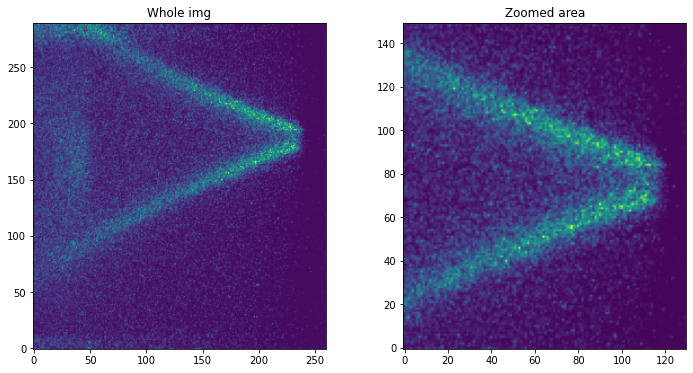

In [5]:
AOI = {  #Area of interest [y, x]
    "Cleave3_14.h5"      : [[],[]],
    "GPScan_5.h5"        : [[],[]],
    "GPScan_133_1.h5"    : [[],[]],
    "gr_flake_full.h5"   : [[110,260],[120,250]],#[[140,230],[175,250]],
    "gr_flake_256.h5"    : [[],[]],#[[110,260],[120,250]],#[[140,230],[175,250]],
    "misfit_Se3d_512.h5" : [[],[]],
    "misfit_Se3d_full.h5": [[],[]],
}
def turnBackToGrid(dat, axisStuff, defaultVal = -1):
    coords = axisStuff["coords"]
    try: 
        a = [[AOI[filename][0][0], min(AOI[filename][0][1], axisStuff["dims"][2])], [AOI[filename][1][0], min(AOI[filename][1][1], axisStuff["dims"][3])]]
        d = (axisStuff["dims"][0], axisStuff["dims"][1], a[0][1] - a[0][0], a[1][1] - a[1][0])
    except:
        d = tuple(axisStuff["dims"][:])
        a = [[0, d[2]], [0, d[3]]]
    
    axisData['dims'] = d
    zeros = np.zeros(d) - defaultVal
    zeros[:, :, 0, :] = 1 #Hvis alle værdier i et billede er den samme virker clusering ikke senere i koden.
    for nr, (x, y) in enumerate(coords):
        zeros[x, y] = dat[nr, a[0][0]:a[0][1], a[1][0]:a[1][1]]
    return zeros                           #-1 er default fejl-værdien

try:
    # img = data[getIndexFromCoord([1, 15])]
    img = data[int(dimension_sizes[0]/2) * dimension_sizes[0] + int(dimension_sizes[1]/2)]
    a = AOI[filename]
    smallImg = img[a[0][0]:a[0][1], a[1][0]:a[1][1]]
    showCoord(imgs=[[img, "Whole img"], [smallImg, "Zoomed area"]])
except:pass

data = turnBackToGrid(data, axisData, defaultVal=0)   #Gør 3d dataet til 4d, udfylder eventuelle huller i dataet og zoomer ind på AOI.


# xarr = loaded.to_xarray()
coords= {
    'posx':list(range(axisData['dims'][0])),
    'posy':list(range(axisData['dims'][1])),
    'angle':list(range(axisData['dims'][2])),
    'energy':list(range(axisData['dims'][3]))
}
xarr = xr.DataArray(np.reshape(data, tuple(axisData['dims'])), coords)

In [6]:
xarr = xarr.compute()

In [7]:
xarr = xarr.transpose("posx", "posy", "energy", "angle").sortby(["energy", "angle","posx","posy"])

In [8]:
xarr

<xarray.DataArray (posx: 49, posy: 39, energy: 130, angle: 150)>
array([[[[-1.83255076e-02, -2.96923518e-03,  3.84045929e-01, ...,
          -3.90781425e-02,  3.08939457e-01,  8.10279995e-02],
         [-1.08907213e-02, -8.18215236e-02,  1.14571169e-01, ...,
           1.52192280e-01,  3.09359640e-01,  8.76743019e-01],
         [-3.36789875e-04,  3.37877393e-01,  5.62364101e-01, ...,
           3.92531514e-01,  2.62507945e-01,  2.83525866e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           4.11785766e-02,  7.62285650e-01,  0.00000000e+00]],

        [[ 7.19680563e-02,  7.66839683e-01,  5.98816216e-01, ...,
           5.69138050e-01, -1.86181404e-02,  6.47797227e-01],
         [ 5.05396247e-01,  7.27993369e-01,  6.28021836e-01, ...,
           1.52951404e-01,  1.07488193e-01,  2.40906164e-01],
         [ 3.65761548e-01,  6.71799541e-01,  1.22347188e+00, ...,
           6.15138531e-01,  2.25761756e-01,  1.84912747e-03],
...
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  6.28628850e-01,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  9.48786438e-02,  6.78553581e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  3.44462931e-01,  3.83137226e-01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           6.89051747e-02,  2.07118928e-01,  1.86037183e-01],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]])
Coordinates:
  * posx     (posx) int32 0 1 2 3 4 5 6 7 8 9 ... 39 40 41 42 43 44 45 46 47 48
  * posy     (posy) int32 0 1 2 3 4 5 6 7 8 9 ... 29 30 31 32 33 34 35 36 37 38
  * angle    (angle) int32 0 1 2 3 4 5 6 7 8 ... 142 143 144 145 146 147 148 149
  * energy   (energy) int32 0 1 2 3 4 5 6 7 ... 122 123 124 125 126 127 128 129

In [9]:
# Klargøring af ARPES
print("Loading trainer")
trainerPath = r"C:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\General coding stuff\ARPES_on_the_fly_arpesnet_206c328\trained_model\arpesnet_n2n_4k.pth"
# trainerPath = r"C:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\Deres\ARPES_on_the_fly_arpesnet_206c328\trained_by_me\arpesnet_60epochs_001.pt"
trainer = an.core.load_trainer(trainerPath)
print("Trainer loaded\n")

encoder = trainer.encoder
decoder = trainer.decoder

encoder.eval()
decoder.eval()

INPUT_SHAPE = (256, 256)
NORM_RANGE = (0, 100)

preprocess = an.transform.Compose(
    [an.transform.Resize(INPUT_SHAPE), an.transform.NormalizeMinMax(*NORM_RANGE)]
)
testing_augmentations = an.transform.Compose(
    [
        an.transform.Resize(INPUT_SHAPE),
        an.transform.NormalizeMinMax(*NORM_RANGE),
    ]
)

def useARPES_on_img(img, pri=False, Numpy=True, decode=True):
    img2 = torch.from_numpy(img)
    img2 = preprocess(img2)
    if(pri): print(img2)
    img2 = testing_augmentations(img2)
    if(not decode): rec = encoder(img2.unsqueeze(0))
    else: rec = decoder(encoder(img2.unsqueeze(0)))

    if(Numpy):
        img2 = img2.detach().squeeze().cpu().numpy()
        try: rec = rec.detach().squeeze().cpu().numpy()
        except: pass

    return img2, rec
print("Machine learning reconstruction is ready")


Loading trainer
GPU not available, using CPU
Trainer loaded

Machine learning reconstruction is ready


c:\Users\Alexa\anaconda3\lib\site-packages\arpesnet\core.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(filepath)
c:\Users\Alexa\anaconda3\lib\site

In [10]:
# def makeBadNoiseMask(removed): #removed = procent af billedet der skal fjernes
#     if(removed != 0):
        # if(removed >= 50):
        #     once = np.zeros(axisData['dims'][2:])
        #     removeThem = np.random.choice(axisData['dims'][2]*axisData['dims'][3], int((1-removed/100)*axisData['dims'][2]*axisData['dims'][3]), replace=False)
        #     for i in removeThem:
        #         once[i//axisData['dims'][2], i%axisData['dims'][2]] = 1
        #     return once, False
        # else:
        #     once = np.zeros(axisData['dims'][2:])+1
        #     removeThem = np.random.choice(axisData['dims'][2]*axisData['dims'][3], int((removed/100)*axisData['dims'][2]*axisData['dims'][3]), replace=False)
        #     for i in removeThem:
        #         once[i//axisData['dims'][2], i%axisData['dims'][2]] = 0
        #     return once, False
    #     once = np.reshape(np.random.choice([0, 1], size=axisData['dims'][2]*axisData['dims'][3], p=[removed/100, (100-removed)/100]), axisData['dims'][2:])
    #     return once, False
    # return None, True

# def makeBadNoiseMask(removed): #removed = procent af billedet der skal fjernes

def bad_noice(imgIn, removed, mask=None):
    # if(mask == None):
    #     mask = makeBadNoiseMask(removed)
    if(removed != 0):
        img = np.copy(imgIn)
        # s = img.shape
        # return img * np.reshape(np.random.choice([0, 1], size=s[0]*s[1], p=[removed/100, (100-removed)/100]), s)
        mean = 1 - removed/100
        n = int(img.size)
        stddev = 0.3
        # stddev = mean
        gauss = stats.truncnorm.rvs((0-mean)/stddev, (1-mean)/stddev,
                             loc = mean, scale = stddev,
                             size = n)
        gauss = np.reshape(gauss, img.shape)
        img *= gauss
        return img
    return imgIn

# prepare data for clustering

In [11]:
spectra = xarr.values.reshape((-1,axisData["dims"][3],axisData["dims"][2]))
shape = tuple(axisData["dims"][:2])
# n_clusters = 2

In [12]:
# if(n_clusters != 1):
#     data = {'4k':[]}
#     for sp in tqdm(spectra):
#         tsp, rec = useARPES_on_img(bad_noice(sp, 10), Numpy=False, decode=False)
#         data["4k"].append(rec.flatten().squeeze().detach().cpu().numpy())
#     data = {k:np.array(v) for k,v in data.items()}
#     km = skc.KMeans(n_clusters=n_clusters)
#     filter_res = km.fit(data['4k'])
#     filter_res = filter_res.labels_
# else:
#     filter_res = np.zeros((shape[0]*shape[1]))
    
# plt.figure()
# plt.imshow(filter_res.reshape(shape),cmap='viridis',aspect='equal')
# print(filter_res.reshape(shape)[0,0])

# km = skc.KMeans(n_clusters=n_clusters)
# filter_res = km.fit(data['4k'])
# filter_res = filter_res.labels_
# AOIMask = (filter_res[int(axisData["dims"][1]**2/2) + int(axisData["dims"][0]/2)]+0)%2

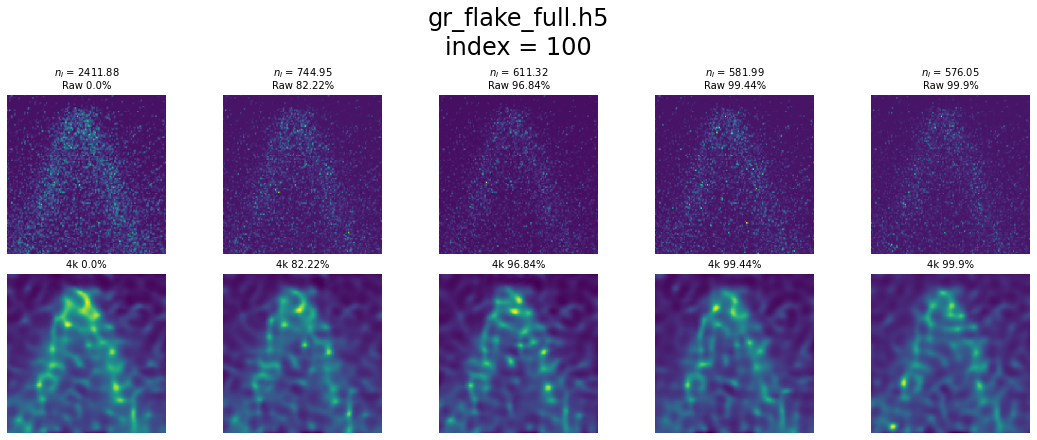

In [13]:
plt.rc("axes", labelsize=20, titlesize=10)   # skriftstørrelse af xlabel, ylabel og title
plt.rc("xtick", labelsize=18, top=True, direction="in")  # skriftstørrelse af ticks, vis også ticks øverst og vend ticks indad
plt.rc("ytick", labelsize=18, right=True, direction="in") # samme som ovenstående
plt.rc("legend", fontsize=12) # skriftstørrelse af figurers legends
plt.rcParams["font.size"] = "20"

ps = 100 - np.round(10**np.linspace(2, -1, 5), 2)

# index = 67*axisData["dims"][1]+25
index = 100
fig, ax = plt.subplots(2, len(ps), figsize=(15,6),layout='constrained')
fig.suptitle(f"{filename}\nindex = {index}")
for nr, p in enumerate(ps):
    # imgRaw = np.copy(spectra[index])
    noisyImg = bad_noice(spectra[index], p)
    img, rec = useARPES_on_img(noisyImg)

    ax[0,nr].imshow(img, cmap='viridis', interpolation='none',origin='lower',aspect='equal')
    ax[0,nr].set_title(f'$n_I$ = {np.sum(noisyImg):.02f}\nRaw {p}%')
    ax[0,nr].axis('off')
    # ax[1,nr].imshow(dct_2d(img)[:32,:32].flatten().squeeze().detach().cpu().numpy(), cmap='viridis', interpolation='none',origin='lower',aspect='equal')
    # ax[1,nr].set_title(f'DCT32 {p}%')
    # ax[1,nr].axis('off')
    ax[1,nr].imshow(rec, cmap='viridis', interpolation='none',origin='lower',aspect='equal')
    ax[1,nr].set_title(f'4k {p}%')
    ax[1,nr].axis('off')


# SC-Score graf med p-afhængighed

In [14]:
# spectra = xarr.values.reshape((-1,axisData["dims"][3],axisData["dims"][2]))

# maxRemoved = {  #
#     "Cleave3_14.h5"      : 0,
#     "GPScan_5.h5"        : -0.35,
#     "GPScan_133_1.h5"    : [[],[]],
#     "gr_flake_full.h5"   : -1,
#     "gr_flake_256.h5"    : -1,
#     "misfit_Se3d_512.h5" : [[],[]],
#     "misfit_Se3d_full.h5": [[],[]],
# }
# # print(np.linspace(2, maxRemoved[filename], 10))
# # ps = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
# # ps = [0, 44, 69, 82, 90, 94.4, 96.9, 98.2, 99, 99.44, 99.69, 99.82, 99.9]
# ps = 100 - np.round(10**np.linspace(2, maxRemoved[filename], 10), 2)
# # ps = [100 - 10**maxRemoved[filename]] #Test
# print(ps)

# n_I = []
# score = {'raw':[], 'DCT32':[], '4k':[]}
# dataLen = spectra.shape[0]

# for nr, p in enumerate(ps):
#     print(f"{nr+1}/{len(ps)}: {p}% removed")

#     #Behandler data
#     data = {'raw':np.zeros((dataLen, INPUT_SHAPE[0]*INPUT_SHAPE[1])), 'DCT32':np.zeros((dataLen, 1024)), '4k':np.zeros((dataLen, 512))}
#     for nr, sp in enumerate(tqdm(list(spectra))):
#         noisyImg = bad_noice(sp, p)
#         tsp, rec = useARPES_on_img(noisyImg, Numpy=False, decode=False)
#         data['raw'][nr] = tsp.flatten().squeeze().detach().cpu().numpy()
#         data['DCT32'][nr] = dct_2d(tsp)[:32,:32].flatten().squeeze().detach().cpu().numpy()
#         data["4k"][nr] = rec.flatten().squeeze().detach().cpu().numpy()

#     try:
#         if(True): #Om kantfilter skal slås til
#             #Laver kant-maske
#             km = skc.KMeans(n_clusters=2)
#             filter_res = km.fit(data['4k'])
#             filter_res = filter_res.labels_
#             AOIMask = (filter_res[int(axisData["dims"][1]**2/2) + int(axisData["dims"][0]/2)]+0)%2

#             #Fjerner kant fra data
#             for nr, (sp, mask) in enumerate(tqdm(zip(spectra, filter_res))):
#                 if mask == (AOIMask+1)%2:
#                     data['raw'][nr] = np.zeros((256,256)).flatten()
#                     data['DCT32'][nr] = np.zeros((1024)).flatten()
#                     data["4k"][nr] = np.zeros((512)).flatten()


#         n_clusters = 8
#         init_idxs = skc.kmeans_plusplus(data['raw'], n_clusters, random_state=seed)[1]
#         for k,v in tqdm(data.items()):
#             if(k in ["raw", "DCT32", "4k"]):
#                 t0 = time.time()
#                 init_clusters = v[init_idxs]
#                 km = skc.KMeans(n_clusters=n_clusters, init=init_clusters)
#                 kres = km.fit(v)
#                 maksScore = skm.silhouette_samples(v, kres.labels_)
#                 count = np.sum(np.where(maksScore>0.95, 0, 1))
#                 score[k].append(np.sum(maksScore-1) / count + 1)  #SC - AC
#                 # score[k].append(skm.silhouette_score(v, kres.labels_)) #SC
#                 n_I.append(np.sum(v))
#     except:
#         print(f"Stopped at {p}%")
#         break

In [15]:
# plt.rc("axes", labelsize=20, titlesize=20)   # skriftstørrelse af xlabel, ylabel og title
# plt.rc("xtick", labelsize=18, top=True, direction="in")  # skriftstørrelse af ticks, vis også ticks øverst og vend ticks indad
# plt.rc("ytick", labelsize=18, right=True, direction="in") # samme som ovenstående
# plt.rc("legend", fontsize=12) # skriftstørrelse af figurers legends
# plt.rcParams["font.size"] = "20"

# fig, ax = plt.subplots(1, figsize=(15,6),layout='constrained')

# x_ax = (axisData["dims"][3] * axisData["dims"][2]) * (100 - np.array(ps[:max(len(score["4k"]), len(score["raw"]))]))
# # x_ax = ps

# # print(x_ax)
# ax.plot(x_ax, score["raw"], "o-", label="Raw")
# ax.plot(x_ax, score["DCT32"], "o-", label="DCT32", color="orange")
# ax.plot(x_ax, score["4k"], "o-", label="4k", color="green")
# ax.set_xlabel("$n_I$")
# # ax.set_xlabel("Procent fjernet fra raw data")
# # ax.set_ylabel("SC - Score")
# ax.set_ylabel("SC-AM - Score")
# ax.set_title(filename)
# ax.set_xscale("log")

# plt.legend()
# plt.grid()

In [16]:
# %matplotlib
# from ipywidgets import *
# import numpy as np
# import matplotlib.pyplot as plt

# x = np.linspace(0, 2 * np.pi)
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# line, = ax.plot(x, np.sin(x))

# def update(w = 1.0):
#     line.set_ydata(np.sin(w + x))
#     fig.canvas.draw_idle()

# interact(update)

# Alle slags score med n_cluster afhængighed

In [17]:
#Behandler data
dataLen = spectra.shape[0]
data = {'Rå':np.zeros((dataLen, INPUT_SHAPE[0]*INPUT_SHAPE[1])), 'DCT32':np.zeros((dataLen, 1024)), 'Ind':np.zeros((dataLen, 512)), 'De':np.zeros((dataLen, INPUT_SHAPE[0]*INPUT_SHAPE[1]))}
for nr, sp in enumerate(tqdm(list(spectra))):
    tsp, rec = useARPES_on_img(sp, Numpy=False, decode=False)
    data['Rå'][nr] = tsp.flatten().squeeze().detach().cpu().numpy()
    data['DCT32'][nr] = dct_2d(tsp)[:32,:32].flatten().squeeze().detach().cpu().numpy()
    data["Ind"][nr] = rec.flatten().squeeze().detach().cpu().numpy()
    data["De"][nr] = decoder(rec).flatten().squeeze().detach().cpu().numpy()

  0%|          | 0/1911 [00:00<?, ?it/s]

In [18]:
if(False): #Om kantfilter skal slås til
    #Laver kant-maske
    km = skc.KMeans(n_clusters=2)
    filter_res = km.fit(data['Ind'])
    filter_res = filter_res.labels_
    AOIMask = (filter_res[int((axisData["dims"][1]*axisData["dims"][0])/2) + int(axisData["dims"][0]/2)]+0)%2

    #Fjerner kant fra data
    for nr, (sp, mask) in enumerate(tqdm(zip(spectra, filter_res))):
        if mask == (AOIMask+1)%2:
            data['Rå'][nr] = np.zeros((256,256)).flatten()
            data['DCT32'][nr] = np.zeros((1024)).flatten()
            data['Ind'][nr] = np.zeros((512)).flatten()
            data["De"][nr] = np.zeros((256,256)).flatten()

In [29]:

score = {'Rå':[], 'DCT32':[], 'Ind':[], 'De':[]}
ns = list(range(2, 12))
score_method = "DB"
gentagelser = 30

for g in tqdm(range(gentagelser)):
    for k,v in data.items():
        score[k].append([])
    print()
    for nr, n in enumerate(ns):
        print(f"g={g}: {nr+1}/{len(ns)}")
        init_idxs = skc.kmeans_plusplus(data['Rå'], n)[1]
        for k,v in data.items():
            if(k in ["Rå", "DCT32", "Ind", "De"]):
                init_clusters = v[init_idxs]
                km = skc.KMeans(n_clusters=n, init=init_clusters, n_init=1)
                kres = km.fit(v)
                if(score_method == "SC-AC"):
                    maksScore = skm.silhouette_samples(v, kres.labels_)
                    count = np.sum(np.where(maksScore>0.95, 0, 1))
                    score[k][g].append(np.sum(maksScore-1) / count + 1)  #SC - AC
                elif(score_method == "SC"):
                    score[k][g].append(skm.silhouette_score(v, kres.labels_)) #SC
                elif(score_method == "CH"):
                    score[k][g].append(skm.calinski_harabasz_score(v, kres.labels_))
                elif(score_method == "DB"):
                    score[k][g].append(skm.davies_bouldin_score(v, kres.labels_))

  0%|          | 0/30 [00:00<?, ?it/s]


g=0: 1/10
g=0: 2/10
g=0: 3/10
g=0: 4/10
g=0: 5/10
g=0: 6/10
g=0: 7/10
g=0: 8/10
g=0: 9/10
g=0: 10/10

g=1: 1/10
g=1: 2/10
g=1: 3/10
g=1: 4/10
g=1: 5/10
g=1: 6/10
g=1: 7/10
g=1: 8/10
g=1: 9/10
g=1: 10/10

g=2: 1/10
g=2: 2/10
g=2: 3/10
g=2: 4/10
g=2: 5/10
g=2: 6/10
g=2: 7/10
g=2: 8/10
g=2: 9/10
g=2: 10/10

g=3: 1/10
g=3: 2/10
g=3: 3/10
g=3: 4/10
g=3: 5/10
g=3: 6/10
g=3: 7/10
g=3: 8/10
g=3: 9/10
g=3: 10/10

g=4: 1/10
g=4: 2/10
g=4: 3/10
g=4: 4/10
g=4: 5/10
g=4: 6/10
g=4: 7/10
g=4: 8/10
g=4: 9/10
g=4: 10/10

g=5: 1/10
g=5: 2/10
g=5: 3/10
g=5: 4/10
g=5: 5/10
g=5: 6/10
g=5: 7/10
g=5: 8/10
g=5: 9/10
g=5: 10/10

g=6: 1/10
g=6: 2/10
g=6: 3/10
g=6: 4/10
g=6: 5/10
g=6: 6/10
g=6: 7/10
g=6: 8/10
g=6: 9/10
g=6: 10/10

g=7: 1/10
g=7: 2/10
g=7: 3/10
g=7: 4/10
g=7: 5/10
g=7: 6/10
g=7: 7/10
g=7: 8/10
g=7: 9/10
g=7: 10/10

g=8: 1/10
g=8: 2/10
g=8: 3/10
g=8: 4/10
g=8: 5/10
g=8: 6/10
g=8: 7/10
g=8: 8/10
g=8: 9/10
g=8: 10/10

g=9: 1/10
g=9: 2/10
g=9: 3/10
g=9: 4/10
g=9: 5/10
g=9: 6/10
g=9: 7/10
g=9: 8/10
g

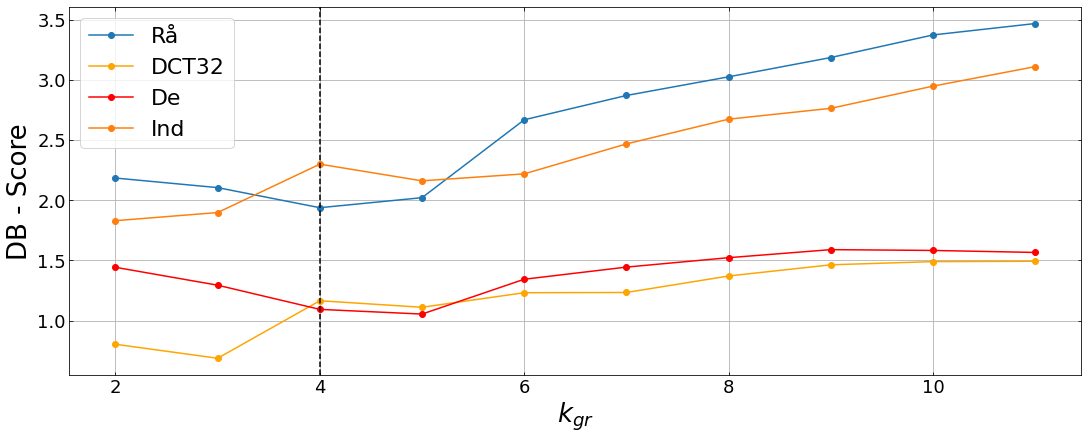

In [ ]:
plt.rc("axes", labelsize=20, titlesize=20)   # skriftstørrelse af xlabel, ylabel og title
plt.rc("xtick", labelsize=18, top=True, direction="in")  # skriftstørrelse af ticks, vis også ticks øverst og vend ticks indad
plt.rc("ytick", labelsize=18, right=True, direction="in") # samme som ovenstående
plt.rc("legend", fontsize=12) # skriftstørrelse af figurers legends
plt.rcParams["font.size"] = "20"

fig, ax = plt.subplots(1, figsize=(15,6),layout='constrained')

for k,v in data.items():
    score[k] = np.array(score[k])

# print(score)

# print(x_ax)
# ax.plot(ns*gentagelser, score["raw"].flatten(), "o", label="Raw")
ax.plot(ns, np.max(score["Rå"], axis=0), "o-", label="Rå")
ax.plot(ns, np.max(score["DCT32"], axis=0), "o-", label="DCT32", color="orange")
# ax.plot(ns*gentagelser, score["4k"].flatten(), "o", label="4k", color="green")
ax.plot(ns, np.max(score["De"], axis=0), "o-", label="De", color="red")
ax.plot(ns, np.max(score["Ind"], axis=0), "o-", label="Ind", color="green")
ax.axvline(x = 4, linestyle = "--", color = 'black')
ax.set_xlabel("$k_{gr}$")
ax.set_ylabel(f"{score_method} - Score")
# ax.set_title(filename)
plt.rc("axes", labelsize=24, titlesize=22)   # skriftstørrelse af `xlabel`, `ylabel` og `title`
plt.rc("xtick", labelsize=22, top=False, direction="out")  # skriftstørrelse af ticks, vis også ticks øverst og vend ticks indad
plt.rc("ytick", labelsize=24, right=True, direction="in") # samme som ovenstående
plt.rc("legend", fontsize=22) # skriftstørrelse af figurers legends

plt.xlabel('$k_{gr}$', fontsize=26)
plt.ylabel(f"{score_method} - Score", fontsize=26)


plt.legend()
plt.grid()

plt.savefig(r"C:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\General coding stuff\Figure\DB-score.png")

In [31]:
# noices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
# # noices = [10]

# bigData = {}
# bigKres = {}

# for nr, noice in enumerate(noices):
#     print(f"{nr+1}/{len(noices)}: {noice}% removed")
#     #Behandler data
#     dataLen = spectra.shape[0]
#     data = {'raw':np.zeros((dataLen, INPUT_SHAPE[0]*INPUT_SHAPE[1])), 'DCT32':np.zeros((dataLen, 1024)), '4k_En':np.zeros((dataLen, 512)), '4k_De':np.zeros((dataLen, INPUT_SHAPE[0]*INPUT_SHAPE[1]))}
#     for nr, sp in enumerate(tqdm(list(spectra))):
#         tsp, rec = useARPES_on_img(bad_noice(sp, noice), Numpy=False, decode=False)
#         data['raw'][nr] = tsp.flatten().squeeze().detach().cpu().numpy()
#         data['DCT32'][nr] = dct_2d(tsp)[:32,:32].flatten().squeeze().detach().cpu().numpy()
#         data["4k_En"][nr] = rec.flatten().squeeze().detach().cpu().numpy()
#         data["4k_De"][nr] = decoder(rec).flatten().squeeze().detach().cpu().numpy()
#     bigData[noice] = data

In [32]:
# showCoord(imgs=[[np.sum(bigData[noices[0]]["raw"].reshape((12, 14, 256, 256)), axis=(2,3)), f"{noices[0]}% removed"]])

In [33]:
# for nr, noice in enumerate(noices):
#     kres = {}
#     n_clusters = 3
#     # init_idxs = skc.kmeans_plusplus(bigData[noice]['raw'], n_clusters, random_state=seed)[1]
#     init_idxs = skc.kmeans_plusplus(bigData[noice]['raw'], n_clusters)[1]
#     for k,v in tqdm(data.items()):
#         t0 = time.time()
#         init_clusters = v[init_idxs]
#         km = skc.KMeans(n_clusters=n_clusters, init=init_clusters, n_init=1)
#         kres[k] = km.fit(v).labels_
#     bigKres[noice] = kres

In [34]:
# plt.rc("axes", labelsize=20, titlesize=12)   # skriftstørrelse af xlabel, ylabel og title
# plt.rc("xtick", labelsize=18, top=True, direction="in")  # skriftstørrelse af ticks, vis også ticks øverst og vend ticks indad
# plt.rc("ytick", labelsize=18, right=True, direction="in") # samme som ovenstående
# plt.rc("legend", fontsize=12) # skriftstørrelse af figurers legends
# plt.rcParams["font.size"] = "12"

# fig, ax = plt.subplots(4, len(noices), figsize=(15,6),layout='constrained')


# for i, (noice, smallKres) in enumerate(bigKres.items()):
#     for j, (k, v) in enumerate(smallKres.items()):
#         ax[j, i].imshow(v.reshape((12, 14)), cmap='viridis', interpolation='none',origin='lower',aspect='equal')
#         ax[j, i].set_title(f'{k}\nnoice {noice}%')
#         ax[j, i].axis('off')
# # print(x_ax)
# # ax.plot(ns, np.mean(score["raw"], axis=0), "o-", label="Raw")
# # ax.plot(ns, np.mean(score["DCT32"], axis=0), "o-", label="DCT32", color="orange")
# # ax.plot(ns, np.mean(score["4k"], axis=0), "o-", label="4k", color="green")
# # ax.set_xlabel("$n_{cluster}$")
# # ax.set_ylabel(f"{score_method} - Score")
# # ax.set_title(filename)

# plt.grid()

In [35]:
# noiceKey = 10

# for noiceKey in noices:
#     fig, ax = plt.subplots(len(bigKres[noiceKey].keys()), n_clusters, figsize=(15,6))
#     fig.suptitle(f"noice: {noiceKey}%")
#     for i, (k, v) in enumerate(bigKres[noiceKey].items()):
#         centers = [np.mean(bigData[noiceKey]['raw'][v==i], axis=0) for i in range(n_clusters)]
#         for j, c in enumerate(centers):
#             ax[i,j].imshow(c.reshape((256,256)), cmap='viridis', aspect='equal', origin='lower')
#             ax[i,j].axis('off')
#             ax[i,j].set_title(f"{k} {j}")